# Lecture 1 : Exact Diagonalisation

The goal of this lecture is to get acquainted with the foundational tool of computational quantum mechanics: Exact Diagonalisation (ED). 
ED is a reliable algorithm that produces 'exact' results which can be trusted, at the cost of scaling exponentially.
ED is often used as a starting point and benchmark for approximate, more powerful methods but asymptotically less expensive methods, to check that they indeed give meaningfull results.

The general idea is that ED relies on diagonalising the hamiltonian exactly using some well known diagonalisation routines like [Lanczos](https://en.wikipedia.org/wiki/Lanczos_algorithm), which are implemented in numpy as [`scipy.sparse.linalg.eighs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html).
As the computational complexity of diagonalising a $M\times M$ matrix scales roughly with the cube of the matrix size $O(M^3)$, if the size of the hilbert space, and therefore of the matrix grows exponentially with the system size such that $M=2^N$, then the total computational cost is $O(2^{3M})$ so it's exponential.

However, diagonalising the matrix is often not the most expensive part of the algorithm. In the notebook below you will see that the most expensive part is to _construct_ the sparse matrix encoding the Hamiltonian. 
In following notebooks we will therefore investigate on computational techniques to reduce the cost of writing the Hamiltonian.

## General things to keep in mind

When working in computational physics, especially when using Python, there are some rules to keep in mind:

- Keep your code simple. A very messy code can house many bugs, and is hard for anybody else to read. Keep small functions that relate to mathetmatical expressions that you can verify somehow by hand, and then compose them together. Do not write huge functions that do many different things
- Benchmark, benchmark, benchmark: It's important to always know what part of your code is the bottleneck. Often check with `%timeit` or similar techniques what part of your algorithm is the most expensive, and be aware of it!
- **Write vectorized code** : always prefer to use numpy functions like `np.exp(array)` to writing for loops or list comprehensions. Numpy is much faster than for loops! And the code will be easy to run on GPUs one day.
- When testing your code, test it on small systems where the runtime is of the order of few seconds at most. Once you are sure it works, test it on the large systems we are interested in because of the physics.

Also
- Keep in mind that we are physicists, and we want to generate plots in the end. Always think about what quantities we want to plot and aim to compute them!
- When a code takes more than 20 seconds to run, it's usually worth it to 'log' or 'save' many quantities such that you don't have to run it again when you want to plot more stuff. 


## Problem Statement:

We will be studying the Transverse Field Ising Model in 1 Dimension

$$
H(J,h) = - J \sum_{\langle i,j\rangle} \sigma_i^z\sigma_j^z -h \sum_i \sigma^x_i 
$$

where J is the anti-ferromagnetic nearest-neighbor coupling, and h is the transverse field.
Remember that by $\sigma_i^x$ we mean

$$
\sigma_i^x = \mathbb{I} \otimes \mathbb{I} \otimes \dots \otimes \sigma^x \otimes \mathbb{I} \dots,
$$
where identities are everywhere except at the site $i$.

Notice that if $h=0$ this is equivalent to the classical ising model.

Without loss of generality we will from now on consider $J=1$ and only vary $h$.

We know that the classical ising Model ($h=0$) has a phase transition if we increase the temperature from a ferromagnetic or antiferromagnetic phase to a disordered phase. 

** How do we identify this phase transition classically? What is the order parameter? **

From now on, we will be looking at the ground state, as well as the first few excited states, defined as

$$
H(h)\ket{\epsilon_i(h)} = \epsilon_i(h) \ket{\epsilon_i(h)}
$$

Notice that the 'classical' term in the hamiltonian, which is $\sum_{\langle i,j\rangle} \sigma_i^z\sigma_j^z$, does not commute with the 'transverse field' term $\sum_i \sigma^x_i $. 

** Can you say something about the ground state of those two different terms, separately? **

### Quantum Phase transition

We want to study what happens if we vary $h$ from 0 to some finite value, like 2.0. We want to look at the magnetization along the z axis defined as

$$
m^z = \frac{1}{N}\sum_i^N \sigma_i^z
$$

You should:
 - Write the Hamiltonian as a $2^N \times 2^N$ sparse matrix.
   - For this first version, you can first write a set of functions like `sigmax(N: int, i: int) -> scipy.sparse` that take a number of sites and the site index and return the  $2^N \times 2^N$ sparse matrix for this operator.
     - a suggestion: start by writing the $2\times 2$ matrices $\sigma^x$, $\sigma^z$ and identity, then use `scipy.sparse.kron` to take the kronecker product of a list of those operators such that it gives the operators that you want.
   - Then, combine this and an analogous `sigmaz` function to write the Hamiltonian.
 - Benchmark the computational runtime of the `sigmax` function for increasing N.
   - Make a plot runtime as a function of N. How is this increasing?
   - Compare this cost to diagonalising the matrix with `scipy.sparse.linalg.eigsh`. Which is dominant? What is the largest size you can reasonably simulate on your laptop with this code?
     - Be careful when using `scipy.sparse.linalg.eigsh`: there are two arguments that you must specify which are very important:
       - `k`, the number of eigenvalues/vectors you are interested in. This is 6 by default, and you might see an error if your matrix is smaller than that size. In general, how many eigenvalues do we want? So what could be the value of `k`that makes sense to use?
       - `which`, if you specify that you want only k eigenvalues/vectors, WHICH k should scipy return to you? The largest? the smallest? Be careful in the difference between _algebraic_ magnitude and (absolute) magnitude. We are interested in the former, not the latter!

 - Do a plot of the total magnetization along the z axis on the ground state as a function of $h$ for different system sizes. What do you learn?
   - For reasonable system sizes you can access (probably up to $N=10-12$) use `scipy.sparse.linalg.eigsh` to compute the ground-state energy for different values of $h$.
   - Compute the expectation value of $m^z$ on the ground state.
   - Do you see some effects when varying the system size?
     - Find the smallest $h$ for which $m^z(h)\neq 0 $, and plot this quantity as a function of the system size $N$. 

 - Can you say something about the gap of th Hamilotnian?

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import kron

from math import prod

from functools import partial, reduce

In [3]:
# Some useful definitions

_sigmax = np.array([[0,1],[1,0]])
_sigmay = np.array([[0,1j],[-1j,0]])
_sigmaz = np.array([[1,0],[0,-1]])
_id = np.eye(2)

In [4]:
# Write a sigmax function
def kronspace_sigma(sigma:np.ndarray, N: int, i: int):
    results = sigma if i == 0 else _id
    for j in range(1, N):
        results = kron(results, (sigma if j == i else _id), format='csr')
    return results


def sigmax(N: int, i: int) -> sp.sparse:
    return kronspace_sigma(_sigmax, N, i)


def sigmaz(N: int, i: int) -> sp.sparse:
    return kronspace_sigma(_sigmaz, N, i)


def mz(N: int) -> sp.sparse:
    return sum(sigmaz(N, i) for i in range(N)) / N

In [12]:
# A typical way to benchmark a function is to write something like the following:
import time

n_vals = np.array([2,4,6,8,10,12,14])

# we will repeat the exxecution of the function a few times to lower the variance/noisiness of the measurement.
n_repetitions = 5

times = []
for N in tqdm(n_vals):
    t0 = time.time()
    for _ in range(n_repetitions):
        _ = sigmax(N, 3)
    dt = time.time() - t0
    times.append(dt/n_repetitions)

100%|██████████| 7/7 [00:00<00:00, 153.06it/s]


In [13]:
def ising_hamiltonian(N: int, J: float, h: float) -> sp.sparse:
    return (- J * sum(sigmaz(N, i) @ sigmaz(N, i+1) for i in range(N-1))
            - J * sigmaz(N, N-1) @ sigmaz(N, 0)
            - h * sum(sigmax(N, i) for i in range(N)))

In [27]:
def calculate_ising(N: int, J: float, h_vals: np.ndarray
                    ) -> tuple[np.ndarray, np.ndarray]:
    mz_mat = mz(N)
    mz_vals = np.empty_like(h_vals)

    for i, h in tqdm(enumerate(h_vals)):
        H = ising_hamiltonian(N, J, h)
        _, v = sp.sparse.linalg.eigsh(H, k=1, which='SA')
        mz_vals[i] = np.squeeze(v.T @ mz_mat @ v)
    
    return h_vals, mz_vals

0it [00:00, ?it/s]

20it [00:00, 559.92it/s]
20it [00:00, 134.70it/s]
20it [00:00, 57.37it/s]
20it [00:00, 30.27it/s]
20it [00:01, 18.35it/s]
20it [00:01, 10.83it/s]
20it [00:03,  5.17it/s]


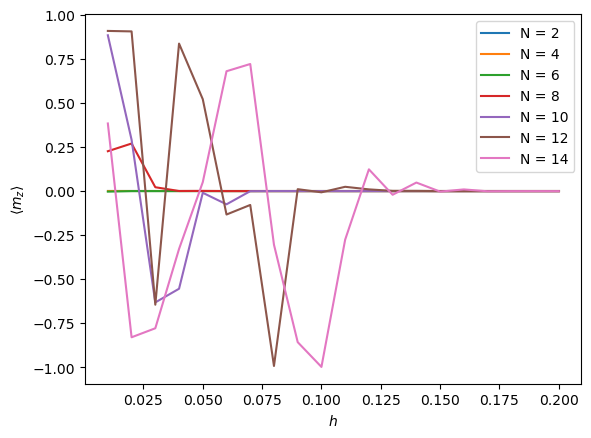

In [94]:
fig, ax = plt.subplots()
ax.set_xlabel("$h$")
ax.set_ylabel(r"$\langle m_z \rangle$")
for N in [2, 4, 6, 8, 10, 12, 14]:
    # At h=0, the ground state is degenerate, so I skip this point
    h_vals, mz_vals = calculate_ising(N, 1.0, np.linspace(0.01, 0.2, 20))
    ax.plot(h_vals, mz_vals, label=f"N = {N}")
ax.legend()
plt.show()

The plots have huge fluctuations, so we need to average over many runs if we want the "true" magnetization plots.

100it [00:00, 612.70it/s]
100it [00:00, 257.33it/s]
100it [00:00, 139.21it/s]
100it [00:01, 85.87it/s]
100it [00:01, 58.09it/s]
100it [00:02, 41.87it/s]
100it [00:03, 31.23it/s]
100it [00:04, 23.65it/s]
100it [00:05, 18.18it/s]
50it [00:03, 14.01it/s]
50it [00:04, 10.32it/s]
20it [00:02,  7.25it/s]
20it [00:04,  4.79it/s]


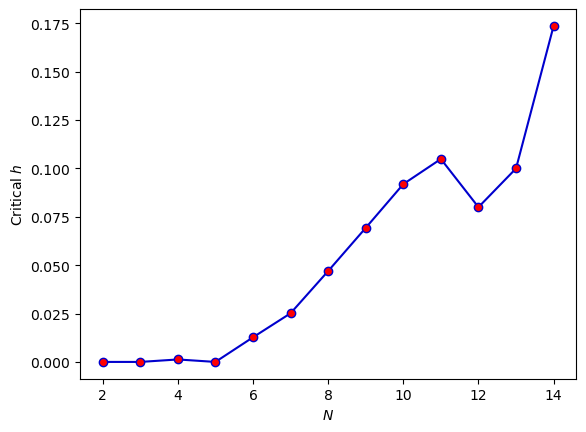

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("$N$")
ax.set_ylabel(r"Critical $h$")

h_nonzero_mz = np.zeros(13)
Ns = np.arange(2, 15)

for N, h_vals in zip(Ns, [np.linspace(0.001, 0.01, 100)] * 3
                     + [np.linspace(0.01, 0.04, 100)] * 2
                     + [np.linspace(0.02, 0.05, 100)] * 2
                     + [np.linspace(0.06, 0.1, 100)] * 2
                     + [np.linspace(0.08, 1.3, 50)] * 2
                     + [np.linspace(0.1, 1.5, 20)] * 2):
    h_vals, mz_vals = calculate_ising(N, 1.0, h_vals)
    if any(np.abs(mz_vals) > 1e-3):
        h_nonzero_mz[N-2] = h_vals[np.max(np.argwhere(np.abs(mz_vals) > 1e-3))]

ax.plot(Ns, h_nonzero_mz, 'o-', c="mediumblue", mfc="red")
plt.show()

## Advanced implementation of Exact Diagonalisation

As discussed in class, the implementation above is quite slow because the complexity of constructing the Hamiltonian scales approximately as $$2^{3N}$$.
In the following, you should construct the Hamiltonian using the more 'advanced' algorithms that directly composes the Hamiltonian in the many-body basis, without using kronecker products.

Remember, the way to go is to interpret the configurations as sequences of bits, where $\uparrow$ is a $0$ and $\downarrow$ is a $1$, such that you can always interpret a configuration like $\uparrow\downarrow\downarrow\uparrow$  as a binary number $0110_2$ which corresponds to the integer index $6_{10}$ in the standard base-10.

This allows us to fill the hamiltonian matrix in numpy, as we can write for example

$$
\text{hamiltonian}[6_{10},7_{10}] = 
\langle 0110_2|H|0111_2 \rangle = 
\langle \uparrow\downarrow\downarrow\uparrow | H | \uparrow\downarrow\downarrow\downarrow \rangle
$$

### Sketch of the implementation

You will need 2 functions, one the inverse of the other, which allow you to convert from a bitstring to an integer and viceversa
```python
def index_to_bitstring(index: int, N : int) -> np.ndarray[bool]:
    """
    Convert the integer index in base-10 `index` to a bitstring of length `N`, where
    1 represent spin up and 0 represent spin down.

    You should return a numpy array of length N.
    """

def bitstring_to_index(bitstring: np.ndarray[bool]) -> int:
    """
    Convert a bitstring of 0s and 1s (or booleans) into the corresponding base-10 integer.
    """
    # Compute the integer value by summing up the powers of 2 for each True value
    int_value = np.sum(bitstring * (2 ** np.arange(len(bitstring))[::-1]))
    
    return int_value

```

If your code is written correctly, you should be able to run without error the following test cell:


In [6]:
def index_to_bitstring(index: int, N : int) -> np.ndarray[bool]:
    """
    Convert the integer index in base-10 `index` to a bitstring of length `N`, where
    1 represent spin up and 0 represent spin down.

    You should return a numpy array of length N.
    """
    bitstring = np.zeros(N, dtype=bool)
    for i in range(N):
        bitstring[N - i - 1] = index % 2
        index = index // 2
    return bitstring

def bitstring_to_index(bitstring: np.ndarray[bool]) -> int:
    """
    Convert a bitstring of 0s and 1s (or booleans) into the corresponding base-10 integer.
    """
    # Compute the integer value by summing up the powers of 2 for each True value
    int_value = np.sum(bitstring * (2 ** np.arange(len(bitstring))[::-1]))
    
    return int_value

In [7]:
N = 8 
sample_value = 88

# Checkc that you return a numpy array
assert isinstance(index_to_bitstring(sample_value, N), np.ndarray)
# Check that you return an array of shape (N,)
assert index_to_bitstring(sample_value, N).shape == (N, )
# check that the value is correct for a sample value of 0 and 123 for which we precompute the result
assert np.all(index_to_bitstring(0, N) == np.array([False,  False,  False,  False,  False, False,  False,  False]))
assert np.all(index_to_bitstring(123, N) == np.array([False,  True,  True,  True,  True, False,  True,  True]))
# Check that the function has the correct inverse
assert bitstring_to_index(index_to_bitstring(sample_value, N)) == sample_value

### Sketch of the implementation (continue)

To compute the matrix elements of the Hamiltonian you will now need a function that returns you all the 'nonzero' entries on every row of the matrix. This function can do the following:
 - take as input a bitstring $\langle x | $, corresponding to the row of the matrix,
 - identify all column bitstring $| y \rangle$  for which the matrix elements $\langle x | H | y \rangle \neq 0$. In particularm you should have $N+1$ different $| y \rangle$ bitstrings: $N$ where you flip a single bit starting from $\langle x |$, and one which is identical to $x$, and corresponds to the diagonal of the hamiltonian.
 - compute the matrix element $h_{xy} = \langle x | H | y \rangle$. To do this:
   - if the $x\neq y$, then it is an off diagonal element and we already know it should be $-h$.
   - if $x==y$, then it's on the diagonal and we should compute it as $h_{xx} = \sum_i x_i x_{i+1}$. to do this you might be helped by writing a separate function that counts the neighboring pairs in a bitstring.
    ```python
    def count_pairs(row_config: np.ndarray[bool]) -> int:
       """
       Returns the total number of pairs - anti-pairs in the bitstring. Pairs are defined as neighbors
       where x_i == x_{i+1} while anti-pairs are defined to be cases where x_i != x_{i+1}.

       For example, for [110011] you have the neighbors (11),(10),(00),(01), (11), (11) [the last one for periodicity]
       so you have 4 pairs and 2 antipairs, so you should return 2.
       """
    ```

Overall, the signature of this function will be something like
```python
def get_connected(J:float, h: float, x_configuration: np.ndarray[bool] ) -> tuple[np.ndarray[bool], np.ndarray[float]):
    """
    For a specific value of J and h, and a row configuration x, stored as a numpy array, return two numpy array which encode the following:
    - the first, the column configurations `y`, stored as a 2D matrix of booleans of size (N+1, N).
    - The second, a vector of floating point matrix elements h_{xy}, of size (N+1)
```

Once you have this function which basically gives you the structure of a row of the Hamiltonian, you can put together the sparse matrix representation of the Hamiltonian by looping along every row. 
Hints:
    - To build the sparse matrix directly, use `ham = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(hilb_dim, hilb_dim))` where `hilb_dim=2**N` and  `values` is a list of matrix elements and `row_indices` and `col_indices` are the row and column indices (in base 10).


Once you have built all this, benchmark this code. Is it faster than before?

In [8]:
def count_pairs(row_config: np.ndarray[bool]) -> int:
    """
    Returns the total number of pairs - anti-pairs in the bitstring. Pairs are defined as neighbors
    where x_i == x_{i+1} while anti-pairs are defined to be cases where x_i != x_{i+1}.

    For example, for [110011] you have the neighbors (11),(10),(00),(01), (11), (11) [the last one for periodicity]
    so you have 4 pairs and 2 antipairs, so you should return 2.
    """
    return 2 * (np.sum(row_config[:-1] == row_config[1:])
                + (row_config[0] == row_config[-1])) - len(row_config)

def get_connected(J:float, h: float, x_configuration: np.ndarray[bool]) -> tuple[np.ndarray[bool], np.ndarray[float]]:
    """For a specific value of J and h, and a row configuration x, stored as a numpy array,
    return two numpy arrays which encode the following:
    - the first, the column configurations `y`, stored as a 2D matrix of booleans of size (N+1, N).
    - The second, a vector of floating point matrix elements h_{xy}, of size (N+1)
    """
    N = len(x_configuration)

    # y = np.tile(x_configuration, (N+1, 1))
    # np.fill_diagonal(y, ~x_configuration)

    h_xy = np.full(N+1, -h)
    h_xy[N] = -J * count_pairs(x_configuration)

    return h_xy

In [21]:
def magnetization_from_index(N, index):
    return (bin(index).count('1') * 2 - N) / N

In [26]:
def ising_hamiltonian_fast(N: int, J: float, h: float) -> sp.sparse:
    values = np.empty(2**N * (N + 1))
    indices = np.empty((2, 2**N * (N + 1)), dtype=int)
    power_string = 2 ** np.arange(N)[::-1]
    for x in range(2 ** N):
        x_configuration = index_to_bitstring(x, N)
        h_xy = get_connected(J, h, x_configuration)
        values[x * (N + 1) : (x + 1) * (N + 1)] = h_xy
        indices[0, x * (N + 1) : (x + 1) * (N + 1)] = x
        indices[1, (x + 1) * (N + 1) - 1] = x
        indices[1, x * (N + 1) : (x + 1) * (N + 1) - 1] = (
            x - (2 * x_configuration - 1) * power_string)
    hlib_dim = 2 ** N
    return sp.sparse.csr_matrix((values, indices), shape=(hlib_dim, hlib_dim))

def calculate_ising_fast(N: int, J: float, h_vals: np.ndarray
                         ) -> tuple[np.ndarray, np.ndarray]:
    mz_vals = np.zeros_like(h_vals)

    for i, h in tqdm(enumerate(h_vals)):
        H = ising_hamiltonian_fast(N, J, h)
        _, v = sp.sparse.linalg.eigsh(H, k=1, which='SA')
        v = v / np.sqrt(np.sum(v**2))
        for j in range(2**N):
            mz_vals[i] += v[j].squeeze()**2 * magnetization_from_index(N, j) / N
    
    return h_vals, mz_vals

20it [00:00, 3142.04it/s]
20it [00:00, 1635.78it/s]
20it [00:00, 651.63it/s]
20it [00:00, 216.34it/s]
20it [00:00, 52.72it/s]
20it [00:01, 13.48it/s]
20it [00:06,  3.13it/s]


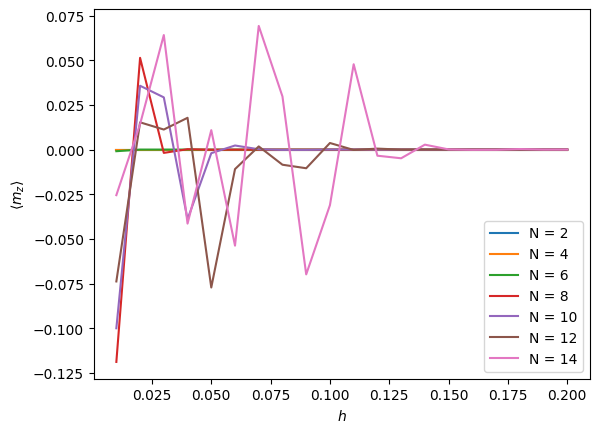

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel("$h$")
ax.set_ylabel(r"$\langle m_z \rangle$")
for N in [2, 4, 6, 8, 10, 12, 14]:
    # At h=0, the ground state is degenerate, so I skip this point
    h_vals, mz_vals = calculate_ising_fast(N, 1.0, np.linspace(0.01, 0.2, 20))
    ax.plot(h_vals, mz_vals, label=f"N = {N}")
ax.legend()
plt.show()

100it [00:00, 2429.79it/s]
100it [00:00, 1927.23it/s]
100it [00:00, 1316.18it/s]
100it [00:00, 853.52it/s]
100it [00:00, 552.50it/s]
100it [00:00, 304.21it/s]
100it [00:00, 169.29it/s]
100it [00:01, 92.13it/s]
100it [00:02, 47.67it/s]
50it [00:02, 23.49it/s]
50it [00:04, 11.66it/s]
20it [00:03,  5.79it/s]
20it [00:07,  2.81it/s]


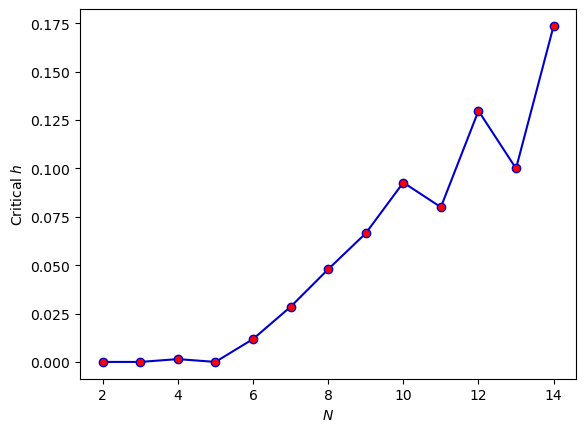

In [169]:
fig, ax = plt.subplots()
ax.set_xlabel("$N$")
ax.set_ylabel(r"Critical $h$")

h_nonzero_mz = np.zeros(13)
Ns = np.arange(2, 15)

for N, h_vals in zip(Ns, [np.linspace(0.001, 0.01, 100)] * 3
                     + [np.linspace(0.01, 0.04, 100)] * 2
                     + [np.linspace(0.02, 0.05, 100)] * 2
                     + [np.linspace(0.06, 0.1, 100)] * 2
                     + [np.linspace(0.08, 1.3, 50)] * 2
                     + [np.linspace(0.1, 1.5, 20)] * 2):
    h_vals, mz_vals = calculate_ising_fast(N, 1.0, h_vals)
    if any(np.abs(mz_vals) > 1e-3):
        h_nonzero_mz[N-2] = h_vals[np.max(np.argwhere(np.abs(mz_vals) > 1e-3))]

ax.plot(Ns, h_nonzero_mz, 'o-', c="mediumblue", mfc="red")
plt.show()

The new method is faster, but only after considerable optimization in the parts of the code involving bitstrings and their conversion to indices.

### Using an estabilished code

**After** having tried yourself to implement this, you can also play around with [quspin](https://quspin.github.io/QuSpin/), which is a good python package to do exact diagonalisation.

The quspin code to write the TFIM Hamiltonian is something like the following
```python
from quspin.operators import hamiltonian  # Hamiltonians and operators
from quspin.basis import (
    spin_basis_1d,
    spinless_fermion_basis_1d,
)  # Hilbert space spin basis

#
##### define model parameters #####
L = 14  # system size
J = 1.0  # spin zz interaction
h = np.sqrt(2)  # z magnetic field strength

basis_spin = spin_basis_1d(L=L, zblock=zblock)

h_field = [[-h, i] for i in range(L)]
J_zz = [[-J, i, (i + 1) % L] for i in range(L)]  # PBC
# define spin static and dynamic lists
static_spin = [["zz", J_zz], ["x", h_field]]  # static part of H

# build spin Hamiltonians
H_spin = hamiltonian(static_spin, [], basis=basis_spin, dtype=np.float64)

# calculate spin energy levels
E_spin = H_spin.eigvalsh()

```
